In [1]:
import math
from typing import Optional, Union
import tensorly as tl

import copy

import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch.utils.data import Dataset, DataLoader

import gymnasium as gym
from gymnasium import logger, spaces
#from gymnasium.envs.classic_control import utils
#from gym.error import DependencyNotInstalled

In [2]:
DEFAULT_X = np.pi
DEFAULT_Y = 1.0

class PendulumEnv(gym.Env):
    def __init__(self, g=10.0, m=1.0, l=1.0):
        self.max_speed = 8
        self.max_torque = 2.0
        self.dt = 0.05
        self.g = g
        self.m = m
        self.l = l

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True

        high = np.array([1.0, 1.0, self.max_speed], dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

    def step(self, u):
        th, thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        dt = self.dt

        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        # costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)
        costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.1 * (u**2)

        newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * dt

        self.state = np.array([newth, newthdot])

        return self._get_obs(), -costs, False, False, {}

    def reset(self, *, seed: Optional[int] = None):
        super().reset(seed=seed)
        high = np.array([DEFAULT_X, DEFAULT_Y])
        low = -high  # We enforce symmetric limits.
        # self.state = self.np_random.uniform(low=low, high=high)
        self.state = [np.random.rand()/100, np.random.rand()/100]
        self.last_u = None

        return self._get_obs(), {}

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([theta, thetadot], dtype=np.float32)

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

In [3]:
class Discretizer:
    def __init__(
        self,
        min_points_states,
        max_points_states,
        bucket_states,
        min_points_actions,
        max_points_actions,
        bucket_actions,
        ):
        self.min_points_states = np.array(min_points_states)
        self.max_points_states = np.array(max_points_states)
        self.bucket_states = np.array(bucket_states)
        self.range_states = self.max_points_states - self.min_points_states

        self.min_points_actions = np.array(min_points_actions)
        self.max_points_actions = np.array(max_points_actions)
        self.bucket_actions = np.array(bucket_actions)
        # Think this better
        self.spacing_actions = (self.max_points_actions - self.min_points_actions) / (self.bucket_actions - 1)

        self.range_actions = self.max_points_actions - self.min_points_actions

        self.n_states = np.round(self.bucket_states).astype(int)
        self.n_actions = np.round(self.bucket_actions).astype(int)
        self.dimensions = np.concatenate((self.n_states, self.n_actions))

    def get_state_index(self, state):
        state = np.clip(state, a_min=self.min_points_states, a_max=self.max_points_states)
        scaling = (state - self.min_points_states) / self.range_states
        state_idx = np.round(scaling * (self.bucket_states - 1)).astype(int)
        return tuple(state_idx.tolist())

    def get_action_index(self, action):
        action = np.clip(action, a_min=self.min_points_actions, a_max=self.max_points_actions)
        scaling = (action - self.min_points_actions) / self.range_actions
        action_idx = np.round(scaling * (self.bucket_actions - 1)).astype(int)
        return tuple(action_idx.tolist())

    def get_action_from_index(self, action_idx):
        return self.min_points_actions + action_idx * self.spacing_actions

In [4]:
class PARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)
        self.factors = torch.nn.ParameterList([
            torch.nn.Parameter(scale * torch.randn(dim, k, dtype=torch.double, requires_grad=True))
            for dim in dims
        ])

    def forward(self, indices):
        factor_vectors = []
        for i in range(indices.shape[1]):
            idx = indices[:, i]
            factor_vectors.append(self.factors[i][idx, :])        
        vectors = torch.stack(factor_vectors, dim=1)

        prod = torch.prod(vectors, dim=1)

        if indices.shape[1] < self.n_factors:
            return torch.matmul(prod, self.factors[-1].T)

        return torch.sum(prod, dim=-1)

In [291]:
nS = 20
nA = 20

In [292]:
def sample_data(gs, m, l, E):
    states, states_next, actions, rewards, tasks = [], [], [], [], []
    for i, g in enumerate(gs):
        env = PendulumEnv(g, m, l)

        discretizer = Discretizer(
            min_points_states=[-1, -5],
            max_points_states=[1, 5],
            bucket_states=[nS]*2,
            min_points_actions=[-2],
            max_points_actions=[2],
            bucket_actions=[nA],
        )

        H = 100

        for e in range(E):
            s, _ = env.reset()
            s_idx = discretizer.get_state_index(s)
            for h in range(H):
                a_idx = np.random.choice(nA)
                a = discretizer.get_action_from_index(a_idx)
                sp, r, d, _, _ = env.step(a)
                sp_idx = discretizer.get_state_index(sp)

                states.append(s_idx)
                states_next.append(sp_idx)
                actions.append(a_idx)
                rewards.append(r)
                tasks.append(i)

                if d:
                    break

                s = sp
                s_idx = sp_idx

    tasks = torch.tensor(tasks)
    states = torch.tensor(states)
    states_next = torch.tensor(states_next)
    actions = torch.tensor(actions)
    rewards = torch.tensor(rewards)

    return tasks, states, states_next, actions, rewards

class Trajectories(Dataset):
    def __init__(self, tasks, states, states_next, actions, rewards, task_id=None):
        self.tasks = tasks
        self.states = states
        self.states_next = states_next
        self.actions = actions
        self.rewards = rewards

        self.task_id = task_id
        if task_id is not None:
            mask = (self.tasks == task_id)
            self.tasks = self.tasks[mask]
            self.states = self.states[mask]
            self.states_next = self.states_next[mask]
            self.actions = self.actions[mask]
            self.rewards = self.rewards[mask]

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        if self.task_id is not None:
            return self.states[idx], self.states_next[idx], self.actions[idx], self.rewards[idx]
        return self.tasks[idx], self.states[idx], self.states_next[idx], self.actions[idx], self.rewards[idx]


In [293]:
class Trajectories(Dataset):
    def __init__(self, tasks, states, states_next, actions, rewards, task_id=None):
        self.tasks = tasks
        self.states = states
        self.states_next = states_next
        self.actions = actions
        self.rewards = rewards

        self.task_id = task_id
        if task_id is not None:
            mask = (self.tasks == task_id)
            self.tasks = self.tasks[mask]
            self.states = self.states[mask]
            self.states_next = self.states_next[mask]
            self.actions = self.actions[mask]
            self.rewards = self.rewards[mask]

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        if self.task_id is not None:
            return self.states[idx], self.states_next[idx], self.actions[idx], self.rewards[idx]
        return self.tasks[idx], self.states[idx], self.states_next[idx], self.actions[idx], self.rewards[idx]


In [294]:
def train_single(Q, loader, lr, epochs):
    gamma = .9
    opt = torch.optim.Adamax(Q.parameters(), lr=lr)
    for e in range(epochs):
        l = 0
        for i, batch in enumerate(loader):
            states, states_next, actions, rewards = batch

            # Update sequential
            # opt.zero_grad()
            # loss = torch.nn.MSELoss()(q_hat, q_target)
            # loss.backward()
            # opt.step()

            # Update Alternating
            for factor in Q.factors:
                with torch.no_grad():
                    q_target = rewards + gamma * Q(states_next).max(dim=1).values
                q_hat = Q(torch.cat((states, actions.unsqueeze(1)), dim=1))

                opt.zero_grad()
                loss = torch.nn.MSELoss()(q_hat, q_target)
                loss.backward()

                with torch.no_grad():
                    for frozen_factor in Q.factors:
                        if frozen_factor is not factor:
                            frozen_factor.grad = None
                opt.step()
            l += loss.item()
        print(f"\rEpoch: {e} - Loss: {l / (i + 1)}", end="")

In [295]:
def train_single_all(Q, loader, lr, epochs):
    gamma = .9
    opt = torch.optim.Adamax(Q.parameters(), lr=lr)
    for e in range(epochs):
        l = 0
        for i, batch in enumerate(loader):
            _, states, states_next, actions, rewards = batch

            # Update Alternating
            for factor in Q.factors:
                with torch.no_grad():
                    q_target = rewards + gamma * Q(states_next).max(dim=1).values
                q_hat = Q(torch.cat((states, actions.unsqueeze(1)), dim=1))

                opt.zero_grad()
                loss = torch.nn.MSELoss()(q_hat, q_target)
                loss.backward()

                with torch.no_grad():
                    for frozen_factor in Q.factors:
                        if frozen_factor is not factor:
                            frozen_factor.grad = None
                opt.step()
            l += loss.item()
        print(f"\rEpoch: {e} - Loss: {l / (i + 1)}", end="")

In [296]:
def train_multiple(Q, loader, lr, epochs):
    gamma = .9
    opt = torch.optim.Adamax(Q.parameters(), lr=lr)
    for e in range(epochs):
        l = 0
        for i, batch in enumerate(loader):
            tasks, states, states_next, actions, rewards = batch

            for factor in Q.factors:
                idx_target = torch.cat((tasks.unsqueeze(1), states_next), dim=1)
                idx_hat = torch.cat((tasks.unsqueeze(1), states, actions.unsqueeze(1)), dim=1)
                with torch.no_grad():
                    q_target = rewards + gamma * Q(idx_target).max(dim=1).values
                q_hat = Q(idx_hat)

                opt.zero_grad()
                loss = torch.nn.MSELoss()(q_hat, q_target)
                loss.backward()

                with torch.no_grad():
                    for frozen_factor in Q.factors:
                        if frozen_factor is not factor:
                            frozen_factor.grad = None
                opt.step()
            l += loss.item()
        print(f"\rEpoch: {e} - Loss: {l / (i + 1)}", end="")

In [297]:
def test_single(Q):
    gs = 1
    env = PendulumEnv(gs, 1, 1)

    discretizer = Discretizer(
            min_points_states=[-1, -5],
            max_points_states=[1, 5],
            bucket_states=[nS]*2,
            min_points_actions=[-2],
            max_points_actions=[2],
            bucket_actions=[nA],
        )

    H = 100
    E = 100
    Gs = []

    for e in range(E):
        G = 0
        s, _ = env.reset()
        s_idx = discretizer.get_state_index(s)
        for h in range(H):
            s_ten = torch.tensor(s_idx).unsqueeze(0)
            a_idx = Q(s_ten).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            s, r, d, _, _ = env.step(a)
            s_idx = discretizer.get_state_index(s)

            G += r

            if d:
                break
        Gs.append(G)
    return Gs

In [298]:
def test_multiple(Q):
    task_id = 1
    gs = 1

    env = PendulumEnv(gs, 1, 1)

    discretizer = Discretizer(
            min_points_states=[-1, -5],
            max_points_states=[1, 5],
            bucket_states=[nS]*2,
            min_points_actions=[-2],
            max_points_actions=[2],
            bucket_actions=[nA],
        )

    H = 100
    E = 100
    Gs = []

    for e in range(E):
        G = 0
        s, _ = env.reset()
        s_idx = tuple([task_id] + list(discretizer.get_state_index(s)))
        for h in range(H):
            s_ten = torch.tensor(s_idx).unsqueeze(0)
            a_idx = Q(s_ten).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            s, r, d, _, _ = env.step(a)
            s_idx = tuple([task_id] + list(discretizer.get_state_index(s)))

            G += r

            if d:
                break
        Gs.append(G)
    return Gs

# Limited trajectories

In [1]:
from torch.utils.data import DataLoader

from src.sampler import PendulumTrajectorySampler
from src.trainer import QNetworkTester, QNetworkTrainer
from src.models import PARAFAC

In [2]:
E = 2
H = 100

nS = 20
nA = 20

gs = [0.5, 1.0, 2.0, 10.0, 100.0]
nT = len(gs)
m = 1
l = 1

task_id = 0

sampler = PendulumTrajectorySampler(gs, m, l, E, H, nS, nA)
sampler.sample_data()

dataset_single = sampler.get_trajectories_dataset(task_id=task_id)
dataset_mult = sampler.get_trajectories_dataset()

loader_single = DataLoader(dataset_single, batch_size=128, shuffle=True)
loader_mult = DataLoader(dataset_mult, batch_size=128, shuffle=True)

In [3]:
k_mono = 100
k_mono_all = 100
k_multi = 100

Q_mono = PARAFAC(dims=[nS, nS, nA], k=k_mono, scale=0.1)
Q_mono_all = PARAFAC(dims=[nS, nS, nA], k=k_mono_all, scale=0.1)
Q_multi = PARAFAC(dims=[nT, nS, nS, nA], k=k_multi, scale=0.1)

In [4]:
lr = 0.001
gamma = 0.9

trainer_mono = QNetworkTrainer(Q_mono, lr, gamma)
trainer_mono_all = QNetworkTrainer(Q_mono_all, lr, gamma)
trainer_multi = QNetworkTrainer(Q_multi, lr, gamma)

In [5]:
trainer_mono.train(loader_single, E, use_tasks=False)
trainer_mono_all.train(loader_mult, E, use_tasks=False)
trainer_multi.train(loader_mult, E, use_tasks=True)

Epoch: 1 - Loss: 42.006835938651236

In [6]:
tester_mono = QNetworkTester(Q_mono, nS, nA, gs, m, l, H)
tester_mono_all = QNetworkTester(Q_mono_all, nS, nA, gs, m, l, H)
tester_multi = QNetworkTester(Q_multi, nS, nA, gs, m, l, H)

In [9]:
G_mono = tester_mono.test(task_id, multi_task=False)
G_mono_all = tester_mono_all.test(multi_task=False)
G_multi = tester_multi.test(multi_task=True)

In [ ]:
E = 2
H = 100

nS = 20
nA = 20

gs = [0.5, 1.0, 2.0, 10.0, 100.0]
nT = len(gs)
m = 1
l = 1

k = 100
lr = 0.001
gamma = 0.9
epochs = 1_000

n_exps = 100
for _ in range(n_exps):
    task_id = 0

    sampler = PendulumTrajectorySampler(gs, m, l, E, H, nS, nA)
    sampler.sample_data()

    dataset_single = sampler.get_trajectories_dataset(task_id=task_id)
    loader_mult = DataLoader(dataset_mult, batch_size=128, shuffle=True)

    Q_mono = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
    trainer_mono = QNetworkTrainer(Q_mono, lr, gamma)
    trainer_mono.train(loader_single, epochs, use_tasks=False)
    tester_mono = QNetworkTester(Q_mono, nS, nA, gs, m, l, H)
    G_mono = tester_mono.test(task_id, multi_task=False)

for _ in range(n_exps):
    sampler = PendulumTrajectorySampler(gs, m, l, E, H, nS, nA)
    sampler.sample_data()

    dataset_mult = sampler.get_trajectories_dataset()
    loader_mult = DataLoader(dataset_mult, batch_size=128, shuffle=True)

    Q_mono_all = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
    trainer_mono_all = QNetworkTrainer(Q_mono_all, lr, gamma)
    trainer_mono_all.train(loader_mult, epochs, use_tasks=False)
    tester_mono_all = QNetworkTester(Q_mono_all, nS, nA, gs, m, l, H)
    G_mono_all = tester_mono_all.test(multi_task=False)

for _ in range(n_exps):
    sampler = PendulumTrajectorySampler(gs, m, l, E, H, nS, nA)
    sampler.sample_data()

    dataset_mult = sampler.get_trajectories_dataset()
    loader_mult = DataLoader(dataset_mult, batch_size=128, shuffle=True)

    Q_multi = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=0.1)
    trainer_multi = QNetworkTrainer(Q_multi, lr, gamma)
    trainer_multi.train(loader_mult, epochs, use_tasks=True)
    tester_multi = QNetworkTester(Q_multi, nS, nA, gs, m, l, H)
    G_multi = tester_multi.test(multi_task=True)

In [1]:
from src.experiments import ExperimentRunner


E = 2
H = 100
nS = 20
nA = 20
gs = [0.5, 1.0, 2.0, 10.0, 100.0]
m = 1
l = 1
k = 100
lr = 0.001
gamma = 0.9
n_exps = 2

# Initialize the ExperimentRunner
experiment_runner = ExperimentRunner(gs, m, l, E, H, nS, nA, k, lr, gamma, n_exps)

# Run single-task experiment for task_id=0
results_single_task_0 = experiment_runner.run_experiments_distributed('single_task', task_id=0)

# Run single-all task experiment
results_single_all_task = experiment_runner.run_experiments_distributed('single_all_task')

# Run multi-task experiment
results_multi_task = experiment_runner.run_experiments_distributed('multi_task')

# Print results
print("Single-task results for task_id=0:", results_single_task_0)
print("Single-all task results:", results_single_all_task)
print("Multi-task results:", results_multi_task)

TypeError: ExperimentRunner.run_single_task_experiment() got multiple values for argument 'task_id'

In [299]:
E = 2

gs = [0.5, 1.0, 2.0, 10.0, 100.0]
nT = len(gs)
m = 1
l = 1

tasks, states, states_next, actions, rewards = sample_data(gs, m, l, E)
dataset_single = Trajectories(tasks, states, states_next, actions, rewards, task_id=0)
dataset_mult = Trajectories(tasks, states, states_next, actions, rewards, task_id=None)
loader_single = DataLoader(dataset_single, batch_size=128, shuffle=True)
loader_mult = DataLoader(dataset_mult, batch_size=128, shuffle=True)

In [307]:
k = 100
lr = 0.001
epochs = 1000

Gs_single = []
for _ in range(5):
    Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
    train_single(Q, loader_single, lr, epochs)
    Gs_single.append(test_single(Q))

Epoch: 999 - Loss: 2.2180673095355238

In [309]:
k = 100
lr = 0.001
epochs = 1000

Gs_single_all = []
for _ in range(5):
    Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
    train_single_all(Q, loader_mult, lr, epochs)
    Gs_single_all.append(test_single(Q))

Epoch: 999 - Loss: 16.352983189453422

In [305]:
lr = 0.001
epochs = 1000
k = 100

Gs_mult = []
for _ in range(5):
    Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=0.1)
    train_multiple(Q, loader_mult, lr, epochs)
    Gs_mult.append(test_multiple(Q))

Epoch: 999 - Loss: 7.7633282938478155

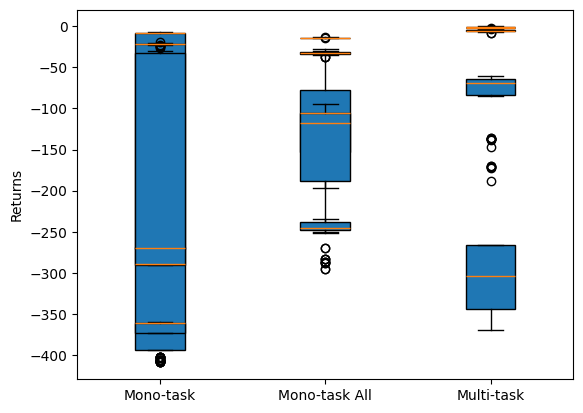

In [310]:
import matplotlib.pyplot as plt


data = [Gs_single, Gs_single_all, Gs_mult]


flattened_data = []
]
for group in data:
    for sublist in group:
        flattened_data.append(sublist)

positions = [1, 2, 3]  # starting position for each main group
data_labels = ['Mono-task', 'Mono-task All', 'Multi-task']

pos = []
current_position = 1
for group in data:
    for sublist in group:
        pos.append(current_position)
    current_position += 1

plt.boxplot(flattened_data, positions=pos, patch_artist=True)

plt.xticks(positions, data_labels)
plt.ylabel('Returns')
plt.show()


# Limited trajectories

In [311]:
E = 10

gs = [0.5, 1.0, 2.0, 10.0, 100.0]
nT = len(gs)
m = 1
l = 1

tasks, states, states_next, actions, rewards = sample_data(gs, m, l, E)
dataset_single = Trajectories(tasks, states, states_next, actions, rewards, task_id=0)
dataset_mult = Trajectories(tasks, states, states_next, actions, rewards, task_id=None)
loader_single = DataLoader(dataset_single, batch_size=128, shuffle=True)
loader_mult = DataLoader(dataset_mult, batch_size=128, shuffle=True)

In [312]:
k = 100
lr = 0.001
epochs = 1000

Gs_single = []
for _ in range(5):
    Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
    train_single(Q, loader_single, lr, epochs)
    Gs_single.append(test_single(Q))

Epoch: 999 - Loss: 2.8857756697320416

In [313]:
k = 100
lr = 0.001
epochs = 1000

Gs_single_all = []
for _ in range(5):
    Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
    train_single_all(Q, loader_mult, lr, epochs)
    Gs_single_all.append(test_single(Q))

Epoch: 999 - Loss: 23.813175343208062

In [314]:
lr = 0.001
epochs = 1000
k = 100

Gs_mult = []
for _ in range(5):
    Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=0.1)
    train_multiple(Q, loader_mult, lr, epochs)
    Gs_mult.append(test_multiple(Q))

Epoch: 999 - Loss: 13.041375005348712

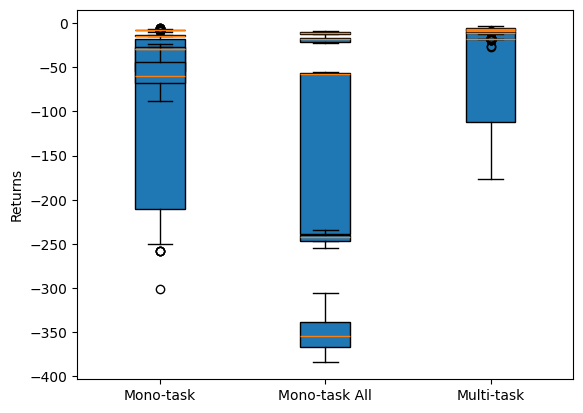

In [316]:
import matplotlib.pyplot as plt


data = [Gs_single, Gs_single_all, Gs_mult]


flattened_data = []

for group in data:
    for sublist in group:
        flattened_data.append(sublist)

positions = [1, 2, 3]  # starting position for each main group
data_labels = ['Mono-task', 'Mono-task All', 'Multi-task']

pos = []
current_position = 1
for group in data:
    for sublist in group:
        pos.append(current_position)
    current_position += 1

plt.boxplot(flattened_data, positions=pos, patch_artist=True)

plt.xticks(positions, data_labels)
plt.ylabel('Returns')
plt.show()


# Limited trajectories

In [317]:
E = 100

gs = [0.5, 1.0, 2.0, 10.0, 100.0]
nT = len(gs)
m = 1
l = 1

tasks, states, states_next, actions, rewards = sample_data(gs, m, l, E)
dataset_single = Trajectories(tasks, states, states_next, actions, rewards, task_id=0)
dataset_mult = Trajectories(tasks, states, states_next, actions, rewards, task_id=None)
loader_single = DataLoader(dataset_single, batch_size=128, shuffle=True)
loader_mult = DataLoader(dataset_mult, batch_size=128, shuffle=True)

In [318]:
k = 100
lr = 0.001
epochs = 1000

Gs_single = []
for _ in range(5):
    Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
    train_single(Q, loader_single, lr, epochs)
    Gs_single.append(test_single(Q))

Epoch: 999 - Loss: 6.3277280238626075

In [319]:
k = 100
lr = 0.001
epochs = 1000

Gs_single_all = []
for _ in range(5):
    Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
    train_single_all(Q, loader_mult, lr, epochs)
    Gs_single_all.append(test_single(Q))

Epoch: 312 - Loss: 41.056827858331424

KeyboardInterrupt: 

In [321]:
lr = 0.001
epochs = 1000
k = 100

Gs_mult = []
for _ in range(5):
    Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=0.1)
    train_multiple(Q, loader_mult, lr, epochs)
    Gs_mult.append(test_multiple(Q))

Epoch: 999 - Loss: 21.112267771344023

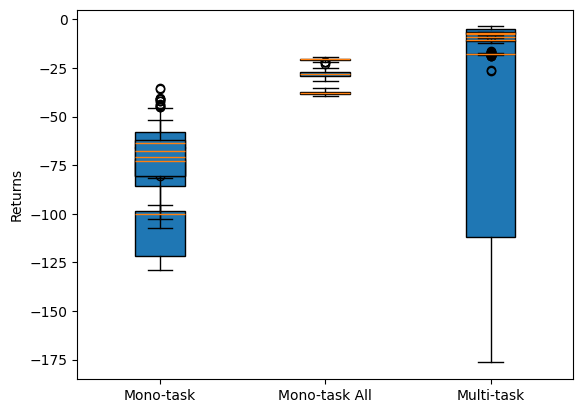

In [320]:
import matplotlib.pyplot as plt


data = [Gs_single, Gs_single_all, Gs_mult]


flattened_data = []

for group in data:
    for sublist in group:
        flattened_data.append(sublist)

positions = [1, 2, 3]  # starting position for each main group
data_labels = ['Mono-task', 'Mono-task All', 'Multi-task']

pos = []
current_position = 1
for group in data:
    for sublist in group:
        pos.append(current_position)
    current_position += 1

plt.boxplot(flattened_data, positions=pos, patch_artist=True)

plt.xticks(positions, data_labels)
plt.ylabel('Returns')
plt.show()
